https://www.kaggle.com/code/marcinrutecki/clustering-methods-comprehensive-study/notebook

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from qvd import qvd_reader

# Import data

In [2]:
file_path = "Y:/Mercanza/ProyectosDVA/CM Proyectos/QVD"
raw_df = qvd_reader.read(file_path + "/vfacturas.qvd")
# raw_df.head()

df_raw = raw_df[["FechaFactura", "Cod_Cli", "TotalFactura"]].copy()
df_raw.head()
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42103 entries, 0 to 42102
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   FechaFactura  42103 non-null  object
 1   Cod_Cli       42103 non-null  object
 2   TotalFactura  42100 non-null  object
dtypes: object(3)
memory usage: 986.9+ KB


# Convert data types

In [3]:
type_table = {"FechaFactura": "int32", "Cod_Cli": "string", "TotalFactura": "float32"}

df_raw = df_raw.astype(type_table)
df_raw["FechaFactura"] = pd.to_datetime(
    df_raw["FechaFactura"], unit="D", origin="1899-12-30"  # Excel (Qlik) base date
)

df_raw.info()
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42103 entries, 0 to 42102
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   FechaFactura  42103 non-null  datetime64[ns]
 1   Cod_Cli       42103 non-null  string        
 2   TotalFactura  42100 non-null  float32       
dtypes: datetime64[ns](1), float32(1), string(1)
memory usage: 822.4 KB


,FechaFactura,Cod_Cli,TotalFactura
0,2000-01-03,21889,20880.0
1,2000-01-03,22013,222706.0
2,2000-01-03,22052,25881.0
3,2000-01-03,22171,103523.0
4,2000-01-04,22020,156600.0


In [4]:
df_raw.describe(include="all", datetime_is_numeric=True)

,FechaFactura,Cod_Cli,TotalFactura
count,42103,42103,4.210000e+04
unique,NaN,5139,NaN
top,NaN,0110,NaN
freq,NaN,3678,NaN
mean,2013-03-12 06:26:06.273187328,NaN,1.411743e+04
min,1992-07-01 00:00:00,NaN,-2.375993e+06
25%,2007-10-29 00:00:00,NaN,1.094900e+02
50%,2013-06-27 00:00:00,NaN,4.549600e+02
75%,2019-03-29 00:00:00,NaN,3.667440e+03
max,2022-11-29 00:00:00,NaN,8.053648e+06


# Aggregate data

In [5]:
df = (
    df_raw.groupby(["Cod_Cli", df_raw["FechaFactura"].dt.year])["TotalFactura"]
    .agg(["sum", "count"])
    .reset_index()
)
df = df.rename(
    columns={
        "FechaFactura": "Year",
        "Cod_Cli": "Code",
        "sum": "Sales",
        "count": "Bills",
    }
)
# df.describe(include='all')
# df.info()
# df.head(10)

# save data for future use
df.to_csv('sales_and_bills.csv', index=False)

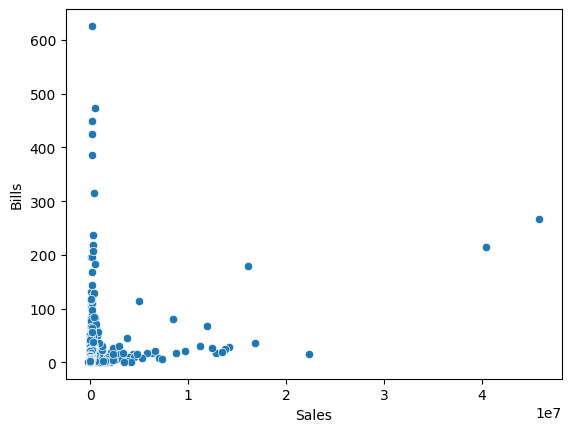

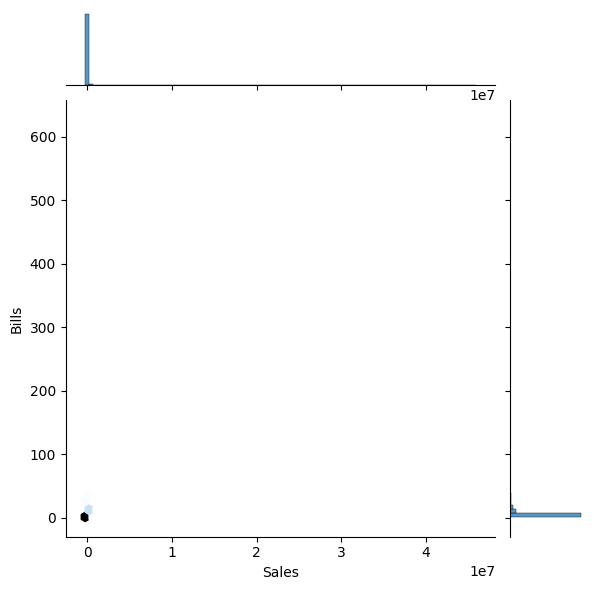

In [6]:
sns.scatterplot(df, x='Sales', y='Bills')
sns.jointplot(df, x='Sales', y='Bills', kind='hex', marginal_kws=dict(bins=100, fill=True))

[Text(0.5, 0, ''), Text(0, 0.5, '')]

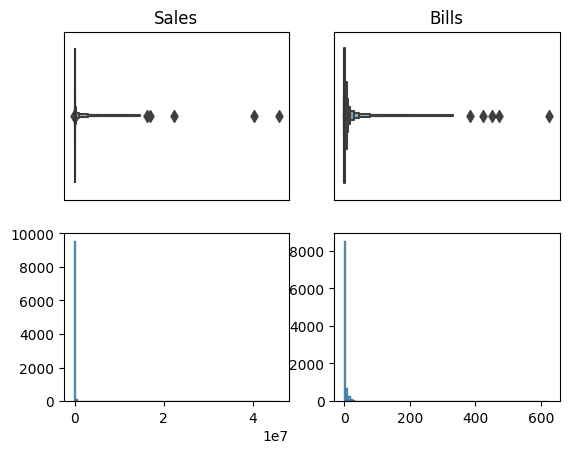

In [7]:
fig, axes = plt.subplots(2, 2)
sns.boxenplot(df["Sales"], ax=axes[0, 0], orient="h")
axes[0, 0].set(title="Sales", xticklabels="", xticks=[], yticks=[])
sns.boxenplot(df["Bills"], ax=axes[0, 1], orient="h")
axes[0, 1].set(title="Bills", xticklabels="", xticks=[], yticks=[])
sns.histplot(df["Sales"], ax=axes[1, 0], bins=100)
axes[1, 0].set(xlabel="", ylabel="")
sns.histplot(df["Bills"], ax=axes[1, 1], bins=100)
axes[1, 1].set(xlabel="", ylabel="")

# Outlier detection

In [8]:
from sklearn.ensemble import IsolationForest

df2 = df.copy()
df2 = df2.drop(["Code", "Year"], axis=1)

In [9]:
model = IsolationForest()
model.fit(df2)

scores = model.decision_function(df2)
anomaly = model.predict(df2)

df2['scores'] = scores
df2['anomaly'] = anomaly

anomaly_index = list(df2.loc[df2['anomaly']==-1].index)
outliers = len(anomaly_index)
total = len(df2.index)
print(
    f"Outliers are {outliers:,} of {total:,} ({outliers / total:.1%})."
)

Outliers are 916 of 9,760 (9.4%).


<AxesSubplot:xlabel='Sales', ylabel='Bills'>

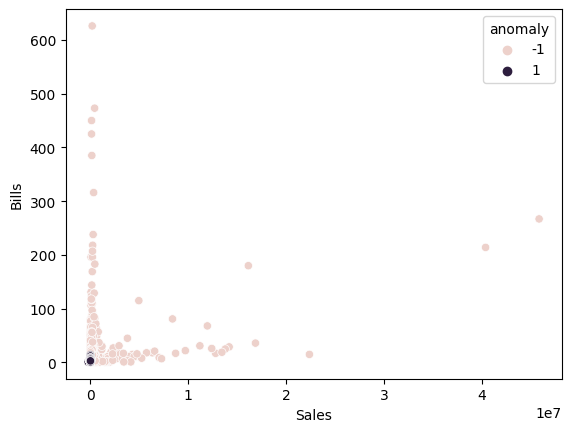

In [10]:
sns.scatterplot(df2, x='Sales', y='Bills', hue='anomaly')

In [11]:
df2 = df2.drop(anomaly_index, axis=0).reset_index(drop=True)

[Text(0.5, 0, ''), Text(0, 0.5, '')]

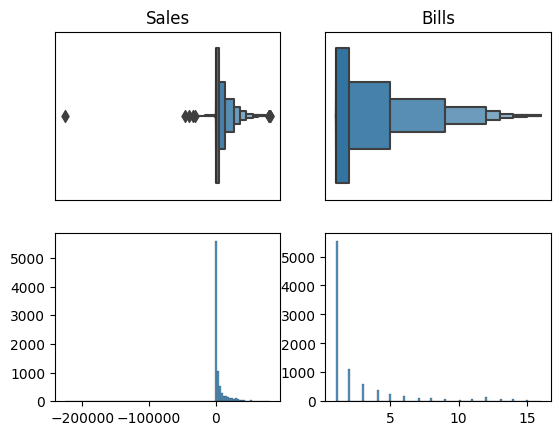

In [12]:
fig, axes = plt.subplots(2, 2)
sns.boxenplot(df2["Sales"], ax=axes[0, 0], orient="h")
axes[0, 0].set(title="Sales", xticklabels="", xticks=[], yticks=[])
sns.boxenplot(df2["Bills"], ax=axes[0, 1], orient="h")
axes[0, 1].set(title="Bills", xticklabels="", xticks=[], yticks=[])
sns.histplot(df2["Sales"], ax=axes[1, 0], bins=100)
axes[1, 0].set(xlabel="", ylabel="")
sns.histplot(df2["Bills"], ax=axes[1, 1], bins=100)
axes[1, 1].set(xlabel="", ylabel="")

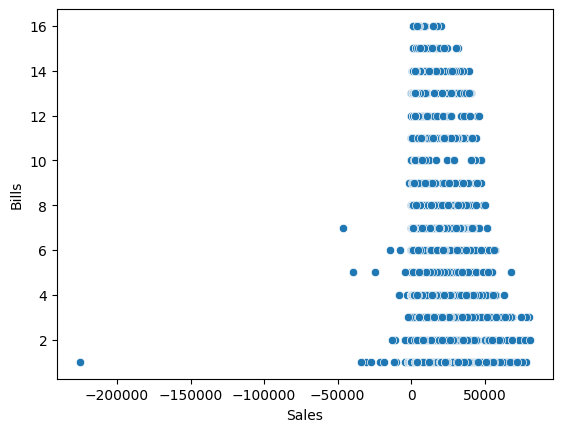

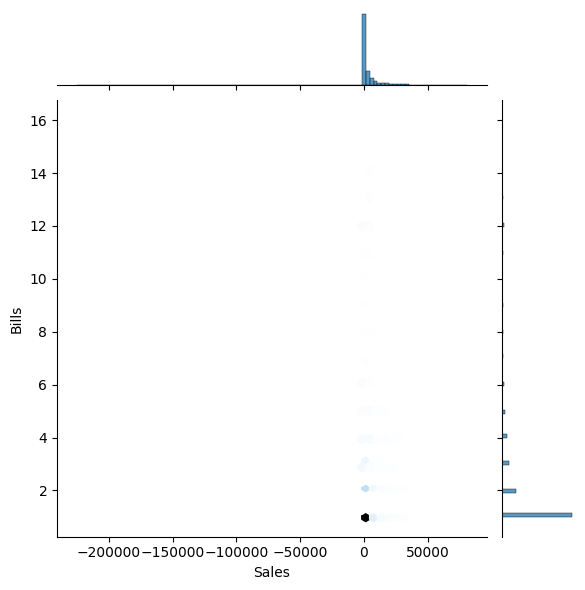

In [13]:
sns.scatterplot(df2, x='Sales', y='Bills')
sns.jointplot(df2, x='Sales', y='Bills', kind='hex', marginal_kws=dict(bins=100, fill=True))

In [14]:
df2.drop(['scores', 'anomaly'], axis=1, inplace=True)

# Scaling data

<AxesSubplot:xlabel='Sales', ylabel='Bills'>

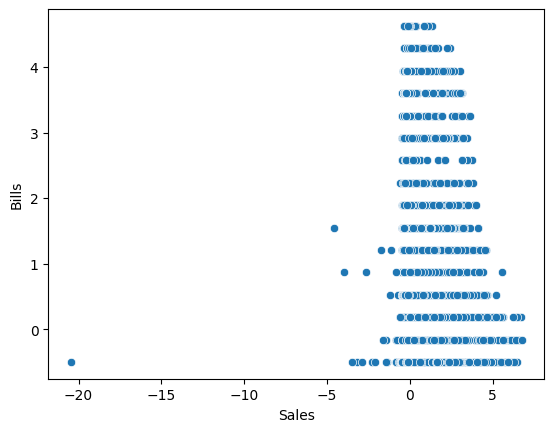

In [15]:
from sklearn.preprocessing import StandardScaler
df3 = pd.DataFrame(StandardScaler().fit_transform(df2), columns=['Sales', 'Bills'])
sns.scatterplot(df3, x='Sales', y='Bills')

# Determining The Optimal Number Of Clusters

## Elbow method

In [ ]:
from sklearn.cluster import KMeans

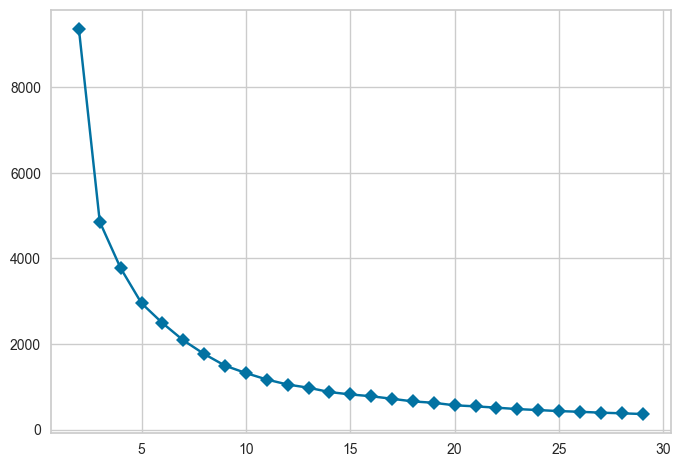

In [33]:
wcss = []
for i in range(2, 30):
    kmeans = KMeans(i, random_state = 42)
    kmeans.fit(df3)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 30), wcss, marker='D')

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

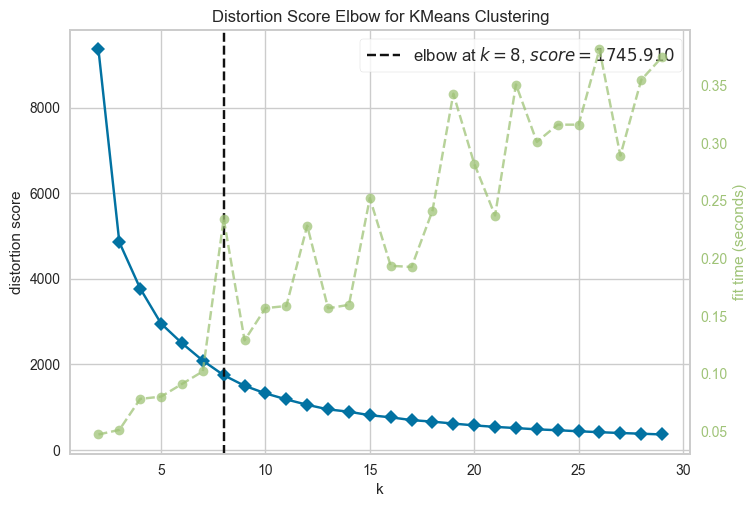

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
visualizer = KElbowVisualizer(KMeans(), k=(2, 30))
visualizer.fit(df3)
visualizer.show()

## Silhouette Method

In [26]:
from sklearn.metrics import silhouette_score

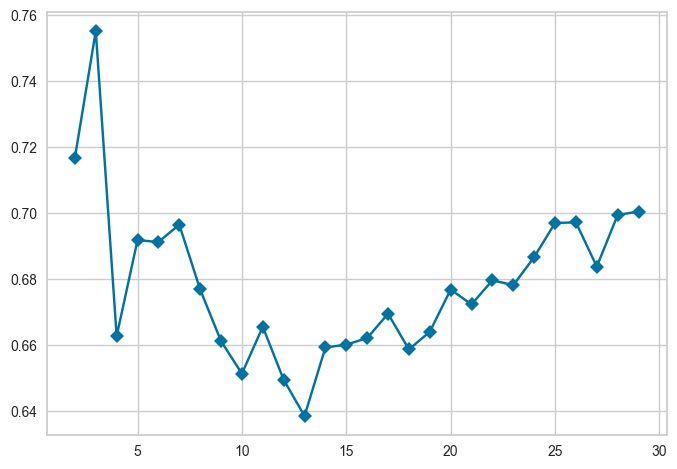

In [34]:
silh = []
for i in range(2, 30):
    kmeans = KMeans(i, random_state=42)
    kmeans.fit_predict(df3)
    score = silhouette_score(df3, kmeans.labels_)
    silh.append(score)
plt.plot(range(2, 30), silh, marker='D')

In [39]:
from yellowbrick.cluster import SilhouetteVisualizer

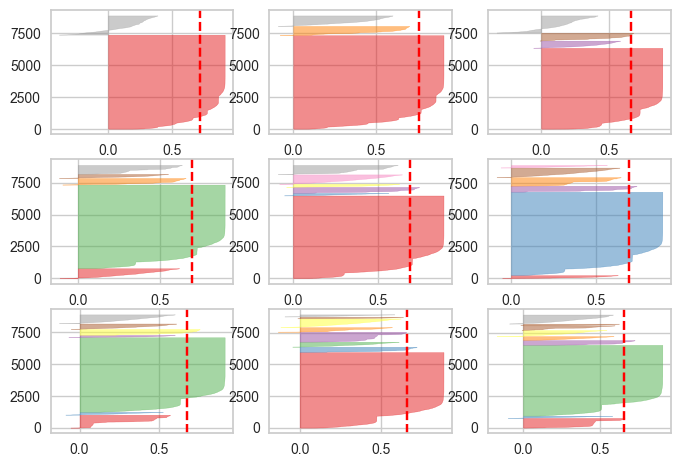

In [46]:
fig, ax = plt.subplots(3,3)

for i in range(2, 11):
    kmeans = KMeans(i, random_state=42)
    q, mod = divmod(i-2, 3)
    # print(f"i={i}, q={q} and mod={mod}")
    visualizer = SilhouetteVisualizer(kmeans, ax=ax[q][mod])
    visualizer.fit(df3)